# Deep Convolutional Generative Adversarial Network (DCGAN) Tutorial

**Authors**:
Sufiyan Ahmed Bukhari,
Travis Dow,
Abdelrahman Elnaggar,
Subroto Nath,
Sujesh Padhi

**Course**:
ENEL 645

**Date**:
March 6, 2023

## References
N. Inkawhich. DCGAN Tutorial [Online]. Available: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

PyTorch. PyTorch Examples [Online]. Available: https://github.com/pytorch/examples

Z. Liu, et al., "Deep Learning Face Attributes in the Wild," *Proceedings of International Conference on Computer Vision (ICCV)*, 2015.

I. Goodfellow, et al., "Generative Adversarial Networks," *Adv. Neural Inf. Process. Syst*, vol. 27, pp. 2672–2680, 2014.

S. Chintala, et al. GanHacks [Online]. Available: https://github.com/soumith/ganhacks

## Introduction

Through an example, this tutorial provides an introduction to Deep Convolutional Generative Adversarial Networks (DCGAN). It involves training a generative adversarial network (GAN) to create novel human faces by presenting it with images of real human faces and then training a combination of a generator deep learning model and a discriminator deep learning model. This document is heavily influenced by a [similar tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html), but aims to offer a more beginner-friendly and comprehensive explanation of the implementation and clarify the mechanism behind the success of this model.


## Generative Adversarial Networks

![image](spider-meme.jpg)

### What is a GAN?

A Generative Adversarial Network (GAN) is a type of neural network architecture that consists of two separate networks working in conjunction: a generator network and a discriminator network. The generator network is trained to generate synthetic data samples from a random noise seed that resemble the training data, while the discriminator network is trained to apply binary classification to images to distinguish between real and fake data samples.

During the training process, the generator network tries to generate realistic data samples that can fool the discriminator network into thinking they are real, while the discriminator network tries to correctly classify the real and fake data samples. As a result of this adversarial training process, the generator network gradually improves its ability to generate increasingly realistic data samples, while the discriminator network becomes better at identifying fake data samples. In this way, both neural networks continuously improve each other's functionality as they "duel."

GANs are commonly used for generative tasks such as image and video generation, text generation, and music generation (among others). They have gained popularity in recent years due to their ability to generate high-quality, realistic data samples that can be used for various applications, including art, entertainment, and data augmentation. However, there has also been much discussion about the ethical implications of training deep learning models using human generated art and then having the model produce art in a similar style without acknoweledging the original artists. Several ongoing lawsuits are in progress and we will have to wait and see where the legal system lands on this issue.

### What is a DCGAN?

It is a type of Generative Adversarial Network (GAN) that uses a deep convolutional neural network (CNN) as the generator and a deep CNN as the discriminator.

DCGANs were introduced to improve the quality of images generated by GANs much the same way CNNs were used originally to improve image detection over regular deep neural networks. DCGANs use convolutional layers in the generator network to learn hierarchical representations of images and produce high-quality images with rich details and textures. Additionally, DCGANs use convolutional layers in the discriminator network to enable it to learn more complex decision boundaries and better distinguish between real and fake images.

DCGANs have become a popular model for image synthesis tasks and have been used to generate realistic images of objects, animals, and even human faces. They have also been used in style transfer tasks, where the generator network is trained to convert images from one style to another, such as turning a photograph into a painting. Overall, DCGANs have significantly improved the quality and realism of generated images and have paved the way for many exciting applications of GANs in computer vision and graphics.


## Tutorial

**Model Overview**

Our model will take 3x64x64 input images of human faces. First, the discriminator uses this input to learn what real images of human faces should look like. Second, the generator creates a 3x64x64 image using random noise as a base. This generated image is given to the discriminator which outputs a single probability value predicting if it is a real image or a fake image. The resulting labels of real or fake are provided to the generator so that it can learn from which images were accuractely guessed as fakes. This process is then repeated multiple times to gradually improve the results of both networks.


### Phase 1. Initialization

First, we need to set up several parameters we'll be using throughout the tutorial. Here is a breakdown of which and what they do:

#### Input Parameters

|Input Variable|Variable Description|Initial Value|
|:-----|:-----------------|:----------|
|data_path|The relative path to the dataset from this file (must be set by user) |i.e. ./data/faces|
|batch_size|The batch size used in training. The [DCGAN paper](https://arxiv.org/abs/1406.2661) uses a batch size of 128.|128|
|image_size|The dimensions (height == width) of the images used for training|64|
|n_channels|number of color channels in the input images. (RGB Channel)|3|
|n_input|length of latent vector|100|
|generator_features|relates to the depth of feature maps carried through the generator|64|
|discriminator_features|sets the depth of feature maps propagated through the discriminator|64|
|n_epochs|number of training epochs to run (must be set by user) |5|
|learning_rate|learning rate for training|0.0002|

<br />

**Dataset**

In this tutorial we have used human faces from the dataset [Celeb-A Faces dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) (which can also be downloaded from [Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ))

**Step 1.** Download the file named **img_align_celeba.zip** available from the above links.

**Step 2.** Create a new directory named "*faces*" in your project.

**Step 3.** Extract the ***img_align_celeba.zip*** file into the new directory (faces) created in *Step 2*. This step is crucial since we plan to use the ImageFolder dataset class, which mandates the existence of subdirectories within the root folder of the dataset. With this prerequisite met, we can proceed with creating the dataset, setting up the dataloader, specifying the device to operate on, and ultimately visualize some of the training data.
            The resultant directory hiearchy should be:
            
            ...<faces>
                ...<img_align_celeba>
                    ... 000001.jpg
                    ... 000002.jpg
                    ... 000003.jpg
                    ...
                    


**Step 4.** Go back to "***data_path***" variable initialized before and update the path where path ends with the folder "celeba". 

            <path to faces from this file>/faces
            
**Step 5.** Import the various libraries we will need for this project.


In [1]:
# -----------------------------------------
# Code begins
# -----------------------------------------

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# Other libraries
import numpy as np
from PIL import Image

# Set a manual random seed so the results can be reproduced
manualSeed = 777
torch.manual_seed(manualSeed)

**Step 6:** Initialize the aforementioned variables

In [2]:
# -----------------------------------------
# User-specific directory for dataset !!! change this !!!
# -----------------------------------------
data_path = "data/faces"

# -----------------------------------------
# Batch size during training
# -----------------------------------------
batch_size = 128

# -----------------------------------------
# Height/width of training images. All images will be resized to this size using a transformer.
# -----------------------------------------
image_size = 64

# -----------------------------------------
# Number of channels in the training images. For color images this is 3
# -----------------------------------------
n_channels = 3

# -----------------------------------------
# Size of z latent vector (i.e. size of generator input)
# -----------------------------------------
n_input = 100

# -----------------------------------------
# Size of feature maps in generator
# -----------------------------------------
generator_features = 64

# -----------------------------------------
# Size of feature maps in discriminator
# -----------------------------------------
discriminator_features = 64

# -----------------------------------------
# Number of training epochs
# -----------------------------------------
n_epochs = 3

# -----------------------------------------
# Learning rate for optimizers
# -----------------------------------------
learning_rate = 0.0002


### Phase 2. Data Augmentation

Data augmentation is a technique used in machine learning and deep learning to increase the size and diversity of a training dataset without actually collecting new data. This technique involves applying various transformations to the existing data, resulting in modified versions of the original data samples that can be used for training.

Data augmentation is an important technique for improving the generalization and robustness of deep learning models, including DCGANs. The purpose of data augmentation is to expose the model to a wider range of variations in the input data. By randomly applying different transformations, such as rotations, translations, scaling, flipping, and adding noise, the model learns to recognize and generate variations of the same image, even if they appear in different poses, orientations, or lighting conditions.

In summary, data augmentation is an important technique for improving the performance of machine learning models, especially in tasks such as image classification, object detection, and natural language processing. Because our dataset is human faces, the only augmentation we will perform is resizing the input images so they are uniform and small enough that we can run our model over the dataset in a reasonable time frame. Rotating the images in our dataset doesn't make much sense, because human faces generally only appear in one orientation, so we would prefer our model learns them that way. We could reflect our images along the y-axis, but our dataset is already quite large and our training period will take quite a while as it is.


#### Transform Functions Used:

1. `Compose()`:<br />Compose function is a function that combines multiple image transformation functions into a single pipeline or sequence.<br /><br />
    
2. `Resize()`:<br />It allows you to standardize the size of input images.<br /><br />

3. `CenterCrop()`:<br />It crops the input images at the center. <br /><br />
    
4. `ToTensor()`:<br />Convert a PIL Image or ndarray to tensor and scale the values accordingly\*.<br /><br />
    
5. `Normalize()`:<br />Normalization is a technique used to standardize the pixel values of images in a dataset.

The following code is related to loading and preprocessing image data for a deep learning model training. Here are the details of the code:

**Step 1:** The `dset.ImageFolder()` function from PyTorch's torchvision.datasets module is used to load a dataset from a specified directory root, where each subdirectory is assumed to contain images of a specific class.

**Step 2:** The `transforms.Compose()` function from torchvision.transforms module is used to define a sequence of image transformations to be applied to the dataset.

**Step 3:** The specified sequence of transformations includes `transforms.Resize()`, which resizes the images to a specified size, `transforms.CenterCrop()`, which crops the center of the images, `transforms.ToTensor()`, which converts the image data to PyTorch tensors, and transforms. `Normalize()`, which normalizes the image data by subtracting the mean and dividing by the standard deviation.

In [3]:
# Create the dataset
dataset = dset.ImageFolder(root=data_path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),          # Resize
                               transforms.CenterCrop(image_size),      # Crop
                               transforms.ToTensor(),                  # Convert to tensor
                               transforms.Normalize((0.5, 0.5, 0.5),   # Normalize values
                                                    (0.5, 0.5, 0.5))
                           ]))

**Step 4:** The resulting dataset is then wrapped in a PyTorch DataLoader object, which allows for efficient batching, shuffling, and loading of the data during training.

In [4]:
# Create the dataloader using the dataset with shuffling.
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         shuffle=True, 
                                         num_workers=1)

**Step 5:** The device (CPU or GPU) is selected based on the availability of a [CUDA-compatible GPU](https://developer.nvidia.com/cuda-toolkit).

In [5]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Step 6:** Finally, the `plt.imshow()` function from the matplotlib.pyplot module is used to plot some training images, which are obtained using the `next(iter(dataloader))` function call. This line creates an image grid using the make_grid function from the vutils (visualization utilities) module of PyTorch. It takes the first 64 images from the real_batch tensor and arranges them in a grid with 2 pixels of padding between each image. The images are then normalized and transposed to the shape (batch_size, height, width, channels) so they can be displayed using imshow from Matplotlib. Finally, `cpu()` is called to move the image data from the GPU to the CPU (if running on a GPU) before it can be displayed.

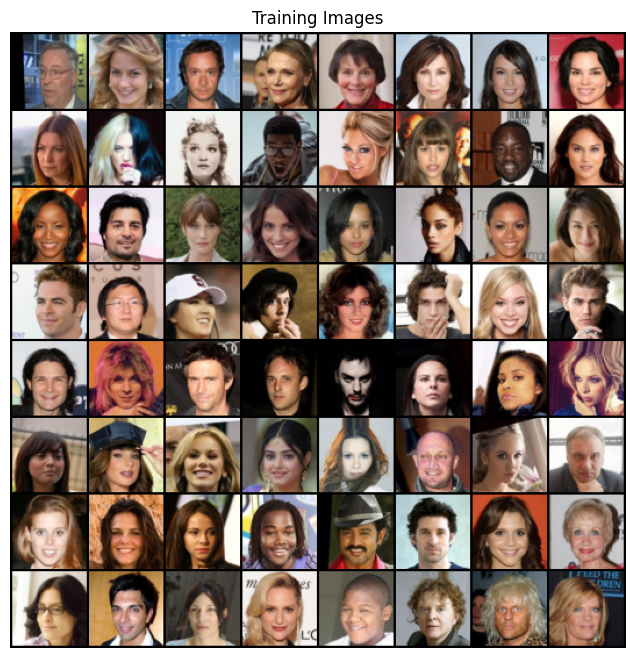

In [6]:
#This line loads the next batch of training images from a PyTorch DataLoader object
real_batch = next(iter(dataloader))

#This line creates a new figure for plotting the images, with a size of 8x8.
plt.figure(figsize=(8,8))

#This line removes the axes from the plot.
plt.axis("off")

#This line adds a title to the plot
plt.title("Training Images")

# This line displays the images
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Phase 3. Implementation

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.


### Weight Initialization
Before we begin initializing the weights of the neural network is an essential step in training deep learning models. Proper initialization of weights can help to accelerate the convergence of the model and improve its ability to generalize to new data.

In the DCGAN architecture, the generator and discriminator models are deep neural networks with many layers. Random initialization of the weights in these models may lead to some of the weights having very large or very small magnitudes, which can result in unstable training and poor performance.

To address this issue, the weights_init function initializes the weights in the generator and discriminator models using a normal distribution with mean 0 and standard deviation 0.02. This initialization ensures that the weights are initially close to zero, which can help to stabilize the training process and accelerate convergence.

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

This step of weight initialization is an important step in the training process of deep neural networks and can have a significant impact on the final performance of the model.

### Generator

In a GAN, the generator model takes in a random noise vector as input and generates a fake image that resembles the real images in the dataset. The goal of the generator is to produce images that are indistinguishable from the real images. The generator model typically consists of a series of deconvolutional layers, also called transpose convolutional layers, that learn to upsample the input noise into an image.

In this tutorial, since we are using a DCGAN architecture so we would follow the same for the generator. DCGAN is a GAN architecture that uses deconvolutional neural networks to generate high-quality images. The DCGAN generator consists of several deep convolutional layers followed by batch normalization and ReLU activation.

Here's a step-by-step explanation of how to create a generator model using the DCGAN architecture:

**Step 1: Define the neural network layers**

The generator has five deconvolutional layers, followed by a Tanh activation function that maps the output to the range [-1, 1]. The first layer takes a n_input-dimensional noise vector as input, and each subsequent layer gradually upsamples the input to produce a 64x64 RGB image.

Let's deep dive into the details of each layer with some real values for the length of the input vector, size of the feature maps and number of channels:

In [8]:
# Layer 1
layer1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)

The first layer is a transposed convolutional layer that takes in a 100-dimensional noise vector as input and outputs a tensor of shape (512, 4, 4). The parameters of this layer are defined as follows:

100: the number of input channels (i.e., the size of the noise vector)
512: the number of output channels (i.e., the number of filters)
4: the kernel size
1: the stride
0: the padding
bias=False: we set this to False because we're using batch normalization, which already includes a bias term.

In [9]:
# Layer 2
layer2 = nn.BatchNorm2d(512)

After the first convolutional layer, we apply batch normalization to normalize the output of the previous layer. Batch normalization helps to stabilize the training process by reducing the internal covariate shift. The BatchNorm2d layer operates on the channel dimension of the tensor and normalizes each channel independently.

In [10]:
# Layer 3
layer3 = nn.ReLU(True)

After batch normalization, we apply the ReLU activation function to introduce non-linearity into the network. ReLU stands for Rectified Linear Unit and is defined as max(0, x). The argument True sets the inplace parameter of ReLU to True, which means that the input tensor will be modified in place and the output tensor will share the same memory.

In [11]:
# Layer 4
layer4 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)

The second layer is another transposed convolutional layer that takes the output of the first layer as input and upsamples it to a tensor of shape (256, 8, 8). The parameters of this layer are defined as follows:

512: the number of input channels (i.e., the number of filters in the previous layer)
256: the number of output channels (i.e., the number of filters)
4: the kernel size
2: the stride
1: the padding
bias=False: we set this to False because we're using batch normalization, which already includes a bias term.

In [12]:
# Layer 5
layer5 = nn.BatchNorm2d(256)

After the second convolutional layer, we again apply batch normalization to normalize the output of the previous layer.

In [13]:
# Layer 6
layer6 = nn.ReLU(True)

We apply the ReLU activation function to further add non-linearity into the network.

In [14]:
# Layer 7
layer7 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)

The third layer is another transposed convolutional layer that takes the output of the second layer as input and upsamples it to a tensor of shape (128, 16, 16). The parameters of this layer are defined as follows:

256: the number of input channels (i.e., the number of output channels from the previous layer)
128: the number of output channels
4: the kernel size
2: the stride
1: the padding
bias=False: we set bias to False since we are using batch normalization after each convolutional layer.

In [15]:
# Layer 8
layer8 = nn.BatchNorm2d(128)

After the third convolutional layer, we again apply batch normalization to normalize the output of the previous layer.

In [16]:
# Layer 9
layer9 = nn.ReLU(True)

This is another ReLU activation function that further adds nonlinearity into the model.

In [17]:
# Layer 10
layer10 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)

The fourth layer is another transposed convolutional layer that takes the output of the third layer as input and upsamples it to a tensor of shape (64, 32, 32). The parameters of this layer are defined as follows:

128: the number of input channels (i.e., the number of output channels from the previous layer)
64: the number of output channels
4: the kernel size
2: the stride
1: the padding
bias=False: we set bias to False since we are using batch normalization after each convolutional layer.

In [18]:
# Layer 11
layer11 = nn.BatchNorm2d(64)

After the fourth convolutional layer, we again apply batch normalization to normalize the output of the previous layer.

In [19]:
# Layer 12
layer12 = nn.ReLU(True)

This is another ReLU activation function that further adds nonlinearity into the model.

In [20]:
# Layer 13
layer13 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

This is the final deconvolutional layer that takes the 32x32x64 tensor as input and produces a 64x64x3 tensor as output. This layer has a kernel size of 4, a stride of 2, and a padding of 1. The output tensor has 3 channels. Thus the final deconvolutional layer upsamples the previous feature map to a 64x64 RGB image with 3 channels (corresponding to red, green, and blue).

In [21]:
# Layer 14
layer14 = nn.Tanh()

The nn.Tanh() function is a non-linear activation function that squashes the output of the generator's final layer to the range [-1, 1]. This is important because the output of the generator is a 64x64 RGB image with pixel values between 0 and 1, but the discriminator expects inputs in the range [-1, 1].

The Tanh function maps input values from the range [-inf, inf] to the range [-1, 1] by applying the following formula:
- Tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

In practice, the Tanh function is often used as the output activation function for generative models, such as the DCGAN, because it produces smooth, continuous outputs that are well-suited for image generation. The Tanh function is also differentiable, which is necessary for training the generator using backpropagation.


Overall, the generator model gradually upsamples the input noise vector from a 1-dimensional vector to a 64x64 RGB image with 3 channels. The batch normalization and ReLU activation functions introduce non-linearity into the model and help prevent overfitting.

**Step 2: Define the Generator Class and the forward method**

Notice, how the inputs we set in the input section (n_input, generator_features, and n_channels) influence the generator architecture in code. n_input is the length of the z input vector, generator_features relates to the size of the feature maps that are propagated through the generator, and n_channels is the number of channels in the output image (i.e. 3 for RGB images).

In [22]:
# Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Input is Z (n_input), going into a convolution
            layer1,  # nn.ConvTranspose2d(n_input, generator_features * 8, 4, 1, 0, bias=False)
            layer2,  # nn.BatchNorm2d(generator_features * 8)
            layer3,  # nn.ReLU(True)
            
            # Input size: (generator_features*8) x 4 x 4
            layer4,  # nn.ConvTranspose2d(generator_features * 8, generator_features * 4, 4, 2, 1, bias=False)
            layer5,  # nn.BatchNorm2d(generator_features * 4)
            layer6,  # nn.ReLU(True)
            
            # Input size: (generator_features*4) x 8 x 8
            layer7,  # nn.ConvTranspose2d(generator_features * 4, generator_features * 2, 4, 2, 1, bias=False)
            layer8,  # nn.BatchNorm2d(generator_features * 2)
            layer9,  # nn.ReLU(True)
            
            # Input size: (generator_features*2) x 16 x 16
            layer10, # nn.ConvTranspose2d(generator_features * 2, generator_features, 4, 2, 1, bias=False)
            layer11, # nn.BatchNorm2d(generator_features)
            layer12, # nn.ReLU(True)
            
            # Input size: (generator_features) x 32 x 32
            layer13, # nn.ConvTranspose2d(generator_features, n_channels, 4, 2, 1, bias=False),
            layer14, # nn.Tanh()
            
            # Output size: (n_channels) x image_size x image_size
        )

    def forward(self, input):
        return self.main(input)

The forward method takes the input noise vector and passes it through the series of deconvolutional layers to generate a fake image.

**Step 3: Create the generator**

In [23]:
# Create the generator
netG = Generator().to(device)

This line creates a new instance of the Generator class and sends it to the specified device (either CPU or GPU). The to method is used to transfer the model parameters to the specified device.

**Step 4: Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.**

In [24]:
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

This line applies the weights_init function to randomly initialize all weights in the generator model. The apply method applies a function recursively to every submodule (i.e., layer) in the model.

**Step 5: Print the model**

In [25]:
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


This line prints a summary of the generator model, including the number of trainable parameters in each layer and the total number of trainable parameters in the model.

### Discriminator


The code defines a Discriminator class, which is a neural network model that takes an image as input and outputs a single scalar value representing whether the input image is real or fake. Here are the main points of the code:

**Step 1:** The class inherits from the `nn.Module` class, which is a base class for all neural network modules in PyTorch.

**Step 2:** The main sequential container is defined to contain the layers of the neural network. The container is defined using `nn.Sequential`, which is a container that allows you to chain together multiple layers in a sequential manner.

**Step 3:** The neural network consists of several layers of convolutional neural networks (CNNs) followed by batch normalization layers, leaky ReLU activation functions, and a final sigmoid activation function.

**Step 4:** The input image is first passed through a 2D convolutional layer (`nn.Conv2d`) with `discriminator_features` output channels, a kernel size of 4, a stride of 2, and padding of 1. The resulting feature map is then passed through a leaky ReLU activation function with a negative slope of 0.2.

**Step 5:** This process is repeated several times with increasing numbers of output channels (discriminator_features * 2, discriminator_features * 4, discriminator_features * 8) until a final 2D convolutional layer with a single output channel (`nn.Conv2d(discriminator_features * 8, 1, 4, 1, 0)`) is reached. This final layer outputs a scalar value between 0 and 1 using a sigmoid activation function (`nn.Sigmoid()`), which represents the discriminator's confidence in the input image being real.

**Step 6:** Batch normalization layers (`nn.BatchNorm2d`) are added after each convolutional layer to normalize the inputs and stabilize the training process. Leaky ReLU activation functions are used instead of regular ReLU functions to allow for a small amount of negative activation values, which can help prevent the "dying ReLU" problem in deep networks.

**Step 7:** The forward method takes an input tensor (input) representing the image and passes it through the layers defined in the main sequential container to produce the discriminator's output. The method returns the output tensor.

**Step 8:** During training, the discriminator network learns to distinguish between real and fake images by adjusting the weights of its layers through backpropagation.

In [26]:
#Discriminator Class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # Input size: (n_channels) x 64 x 64
            nn.Conv2d(n_channels, discriminator_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input size: (discriminator_features) x 32 x 32
            nn.Conv2d(discriminator_features, discriminator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input size: (discriminator_features*2) x 16 x 16
            nn.Conv2d(discriminator_features * 2, discriminator_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input size: (discriminator_features*4) x 8 x 8
            nn.Conv2d(discriminator_features * 4, discriminator_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input size: (discriminator_features*8) x 4 x 4
            nn.Conv2d(discriminator_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            
            # Output size: [0, 1] (a single probability value)
        )
        
    # The forward method takes an input tensor (input) representing the image and passes 
    # it through the layers defined in the main sequential container to produce the 
    # discriminator's output.
    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [27]:
# Creates the Discriminator object by calling the Discriminator class
netD = Discriminator().to(device)
    
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model for verification
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss Functions and Optimizers

With our discriminator ($D$) and generator ($G$) neural networks setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss ([BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss))
function, because we can boil our problem down to a binary classification problem (real vs. fake images). This function is [defined in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. the labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in [the original GAN
paper](https://arxiv.org/abs/1406.2661). 

Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




In [28]:
# Initialize BCELoss function
loss_function = nn.BCELoss()

# Create a fixed batch of noise for the generator to use so we can track its progress
fixed_noise = torch.randn(64, n_input, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizer for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))

### Phase 4. Training

After defining all of the (many) components of the DCGAN framework, we can begin training it. However, it's important to remember that training GANs is an artistic process because if the hyperparameters are set incorrectly, it can result in mode collapse, and it may not be easy to understand the reason for the failure.
We will adhere to Algorithm 1 in [Goodfellow’s Paper](https://arxiv.org/abs/1406.2661) and implement some of the recommended techniques from [ganhacks](https://github.com/soumith/ganhacks) for better performance. Specifically, we will create distinct mini-batches for real and fake images and modify the objective function of the generator to maximize $logD(G(z))$. The training process comprises two primary stages: Part 1 trains the Discriminator, and Part 2 trains the Generator.

**Part 1 - Discriminator Training**

The aim of training the discriminator is to increase the probability of correctly identifying an input as real or fake. To achieve this, Goodfellow suggests updating the discriminator by increasing its stochastic gradient. In practice, we want to maximize the $log(D(x)) + log(1-D(G(z)))$, which represent the probability of the discriminator classifying real and fake inputs correctly. Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps. First, we will construct a batch of real samples and pass it through the $D$, calculate the loss ($log(1-D(G(z)))$), and the gradients in a backward pass. Then, we will create a batch of fake samples with the current generator, pass it through the $D$, calculate the loss ($log(1-D(G(z)))$), and accumulate the gradients in a backward pass. Finally, with the accumulated gradients from both fake and real batches, we will update the discriminator's optimizer.

In [29]:
# Part 1- Update Discriminator network: we want to maximize log(D(x)) + log(1 - D(G(z)))
# Where, log(D(x)) - the log probability of the discriminator output given a real image x.
#        log(1 - D(G(z))) - the log probability of the discriminator output given a generated 
#                           image G(z), where z is a random noise vector.
def train_discriminator(data):
    
    # ------ Train with all-real batch -----
    
    # The discriminator's gradients are set to zero.
    netD.zero_grad()

    # Format this batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0) # real_cpu is a PyTorch tensor residing on the specified device.
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # Forward pass real batch through dsicriminator
    output = netD(real_cpu).view(-1)

    # Calculate loss on all-real batch
    errD_real = loss_function(output, label)

    # Calculate gradients for discriminator in backward pass
    errD_real.backward()
    
    # This line calculates the average output value of the discriminator for the gradients.
    D_x = output.mean().item()

    # ----- Train with all-fake batch -----
    
    # Generate random noise as a seed for the generator
    noise = torch.randn(b_size, n_input, 1, 1, device=device)

    # Generate fake image batch with generator
    fake = netG(noise)
    label.fill_(fake_label)

    # Classify all fake batch with discriminator
    output = netD(fake.detach()).view(-1)

    # Calculate discriminator's loss on the all-fake batch
    errD_fake = loss_function(output, label)

    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()

    # output.mean() calculates the mean of the discriminator's output on the fake images.
    D_G_z1 = output.mean().item()

    # Compute error of discriminator as sum over the fake and the real batches
    errD = errD_real + errD_fake

    # Update discriminator
    optimizerD.step()
    
    return fake, label, D_x, D_G_z1, errD

**Part 2 - Generator Training**

To improve the quality of generated images, we aim to train the Generator by reducing the value of $log(1-D(G(z)))$, as originally proposed. However, this approach was found to be inadequate, particularly during the initial stages of learning, according to Goodfellow. To address this, we now seek to maximize $log(D(G(z)))$. To achieve this in our code, we first use the Discriminator to classify the output of the Generator from Part 1, calculate the loss for G using real labels as ground truth, compute the gradients of G in a backward pass, and finally update the parameters of G using an optimizer step. While it may seem counter-intuitive to use real labels as ground truth for the loss function, doing so enables us to utilize the $log(x)$ component of the Binary Classification Entropy Loss (BCELoss), which is precisely what we desire.

In [30]:
# Part 2 - Update Generator network: maximize log(D(G(z)))
def train_generator(fake, label):
    
    # The generator's gradients are set to zero.
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    
    # Since we just updated the discriminator, perform another forward pass of all-fake batch through it
    output = netD(fake).view(-1)
    
    # Calculate generator's loss based on this output
    errG = loss_function(output, label)
    
    # Calculate gradients for the generator
    errG.backward()
    D_G_z2 = output.mean().item()
    
    # Update the generator
    optimizerG.step()
    
    return errG, D_G_z2

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.

In [ ]:
# Lists for tracking progress
img_list = []
anim_list = []
G_losses = []
D_losses = []
d_real_acc = []
d_fake_acc = []
g_acc = []
iters = 0

# Training Loop
for epoch in range(0, n_epochs):
    
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        # Train the discriminator - see above
        fake, label, D_x, D_G_z1, errD = train_discriminator(data)
        
        # Tain the generator - see above
        errG, D_G_z2 = train_generator(fake, label)
    
        # Print training stats every 50 iterations
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save generator and discriminator Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save discriminator accuracy for graph
        d_real_acc.append(D_x)
        d_fake_acc.append(D_G_z2)

        # Save generator accuracy for graph
        g_acc.append(1-D_G_z2)
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            
            with torch.no_grad():
                # The fake tensor contains the generated image, moved to the CPU memory for further processing or display.
                fake = netG(fixed_noise).detach().cpu()
                
            # The vutils.make_grid function is being used to create a grid of images from the fake tensor.
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            # Make a list of iterations of the same fake image for visualization of generator improvement
            trans = transforms.ToPILImage()
            anim = trans(fake[0])
            anim_list.append(anim)
            
        iters += 1

[0/3][0/1583]	Loss_D: 1.5809	Loss_G: 2.4533	D(x): 0.3681	D(G(z)): 0.2977 / 0.1142
[0/3][50/1583]	Loss_D: 0.0398	Loss_G: 36.2024	D(x): 0.9750	D(G(z)): 0.0000 / 0.0000
[0/3][100/1583]	Loss_D: 0.0042	Loss_G: 40.5983	D(x): 0.9962	D(G(z)): 0.0000 / 0.0000
[0/3][150/1583]	Loss_D: 0.0002	Loss_G: 39.5445	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/3][200/1583]	Loss_D: 0.0105	Loss_G: 40.6608	D(x): 0.9909	D(G(z)): 0.0000 / 0.0000
[0/3][250/1583]	Loss_D: 0.4190	Loss_G: 4.8251	D(x): 0.9378	D(G(z)): 0.2112 / 0.0350
[0/3][300/1583]	Loss_D: 1.2182	Loss_G: 2.9713	D(x): 0.6188	D(G(z)): 0.3374 / 0.0783
[0/3][350/1583]	Loss_D: 1.1324	Loss_G: 5.8736	D(x): 0.8720	D(G(z)): 0.5537 / 0.0050
[0/3][400/1583]	Loss_D: 1.1929	Loss_G: 7.6043	D(x): 0.8589	D(G(z)): 0.5762 / 0.0019
[0/3][450/1583]	Loss_D: 0.8472	Loss_G: 5.1407	D(x): 0.7450	D(G(z)): 0.3232 / 0.0108
[0/3][500/1583]	Loss_D: 1.0564	Loss_G: 6.4955	D(x): 0.8411	D(G(z)): 0.4929 / 0.0051
[0/3][550/1583]	Loss_D: 0.7754	Loss_G: 3.5871	D(x): 0.5681	D(G(z)): 0.0269 

### Phase 5. Results

**Loss During Training**

This graph illustrates the generator and discriminator's loss over time during the training process. The discriminator's loss is calculated as the sum of all binary cross-entropy loss for both the real and fake batches: log(D(x)) + log(1-D(G(z))) The generator's loss is calculated as the binary cross-entropy loss of discriminator's result of the generator's output (i.e. the generator is trying to fool the discriminator): log(D(G(z)))

**Accuracy During Training**

The discriminator's accuracy is a measurement of how well it predicts if an image belongs to the
real dataset or is one of the generator's fake images. Here we plot the accuracy over time for
both the real and fake datasets. The generator's accuracy is the compliment of the discriminator's
accuracy for the fake dataset.


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

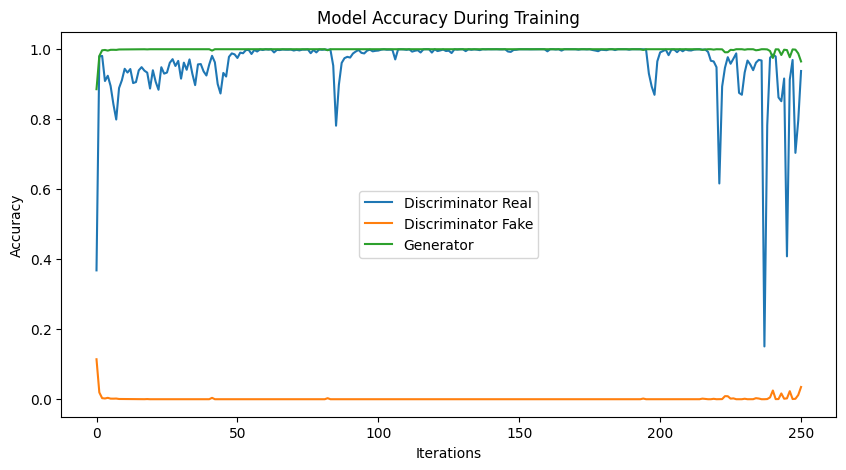

In [171]:
# Plot discriminator accuracy over time
plt.figure(figsize=(10,5))
plt.title("Model Accuracy During Training")
plt.plot(d_real_acc, label="Discriminator Real")
plt.plot(d_fake_acc, label="Discriminator Fake")
plt.plot(g_acc, label="Generator")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Visualization of Generator’s progression**

Here we can visualize the improvements of the DCGAN network output over time. As the generator
continues to learn how to trick the discriminator every iteration, the look of the images will
improve as they become harder and harder for the discriminator to distinguish from real images.
We have selected one image produced by the generator and are tracking it over time to see how 
it improves.

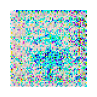

In [172]:
fig = plt.figure(figsize=(1,1))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in anim_list]
ani = animation.ArtistAnimation(fig, ims, interval=34, repeat_delay=1000, repeat=True, blit=True)
HTML(ani.to_jshtml())

**Final Comparison of Real and Fake Images**

Finally, a comparison of our finalized output images to the real images we provided to the model
as training data.

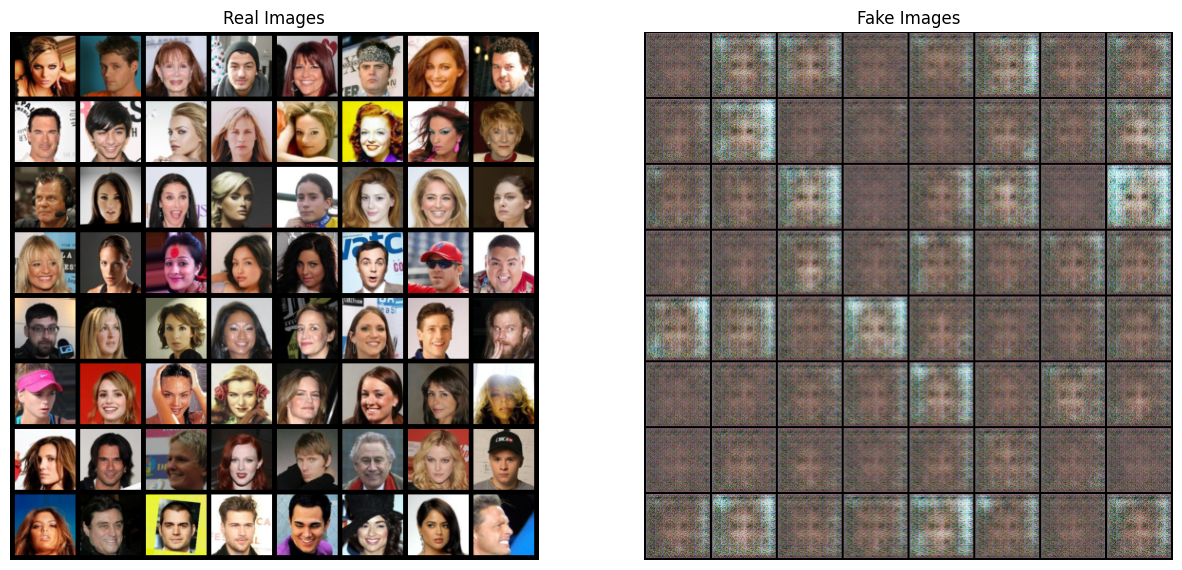

In [173]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot some of the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1, 2, 0)))

# Plot the most recent fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

plt.show()